I am going to follow the regression example in this tutorial to start figuring out nolearn:  
http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

In [1]:
# use the nolearn environment (source activate nolearn) to run this notebook
# Documentation: https://github.com/dnouri/nolearn/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet
from sklearn.datasets import make_regression

%matplotlib inline

#### Eventually, make this into a function that reads the data, cleans it appropriately, shuffles and normalizes it, and splits it into training/test sets

In [2]:
# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
x = pd.read_csv('../parameters_250000.txt', sep=' ')
y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
y = y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)

In [3]:
x = x.values.astype(np.float32)
y = y.values.astype(np.float32)

In [4]:
print x.shape, y.shape

(250000, 4) (250000, 30)


In [5]:
# Normalize and shuffle
mu = np.mean(x, axis=0)
sigma = np.std(x, axis=0)
x_norm = (x-mu)/sigma

combined = np.concatenate((x_norm, y), axis=1)
np.random.shuffle(combined)

x = combined[:,:4]
y = combined[:, 4:]

## Notes on choosing architechture, hyperparameters, etc.

##### Number of Hidden Layers:
Problems that require two hidden layers are rarely encountered, however, NNs with two hidden layers can represent functions with any kind of shape.  There is currently no theoretical reason to use neural networks with any more than two hidden layers.  (from https://web.archive.org/web/20140721050413/http://www.heatonresearch.com/node/707)

##### Number of neurons in hidden layers:
There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

-  The number of hidden neurons should be between the size of the input layer and the size of the output layer. 
-  The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. 
-  The number of hidden neurons should be less than twice the size of the input layer. 
-  Additional rule of thumb for determining an upperbound on the number of hidden neurons that won't result in overfitting is: 

$$ N_h = \frac{N_s}{alpha*(N_i + N_o)} $$

&nbsp;&nbsp;&nbsp;&nbsp; $N_i$ = number of input neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_o$ = number of output neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_s$ = number of samples in training data set
&nbsp;&nbsp;&nbsp;&nbsp; alpha = arbitrary scaling factor (usually between 2-10)

##### Choosing the Learning Rate
-  First, estimate a threshold value at which the cost on the traning data immediately begins decreasing (do this by changing learning rate by orders of magnitude until you get a value where the cost increases during the first few epochs)

In [ ]:
l = InputLayer(shape=(None, x.shape[1]))
l = DenseLayer(l, num_units=32, nonlinearity=nonlinearities.sigmoid)
# l = DenseLayer(l, num_units=10, nonlinearity=nonlinearities.linear)
l = DenseLayer(l, num_units=y.shape[1],
               nonlinearity=nonlinearities.linear)
net = NeuralNet(l, regression=True, update_learning_rate=0.5, verbose=1,
                max_epochs=100)
net.fit(x, y)
print(net.score(x, y))


# Neural Network with 1150 learnable parameters

## Layer information

  #    name    size
---  ------  ------
  0               4
                 32
                 30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.00182       0.00120      1.51145  0.60s
      2       0.00093       0.00082      1.13689  0.52s
      3       0.00072       0.00066      1.09656  0.53s
      4       0.00061       0.00059      1.03100  0.53s
      5       0.00055       0.00053      1.04358  0.53s
      6       0.00048       0.00044      1.07292  0.53s
      7       0.00041       0.00040      1.02491  0.53s
      8       0.00038       0.00038      1.00811  0.53s
      9       0.00036       0.00036      1.00346  0.53s
     10       0.00035       0.00035      1.00120  0.53s
     11       0.00034       0.00034      0.99901  0.53s
     12       0.00032       0.00033      0.99658  0.54s
     13       0.00031       0.00032      0.994

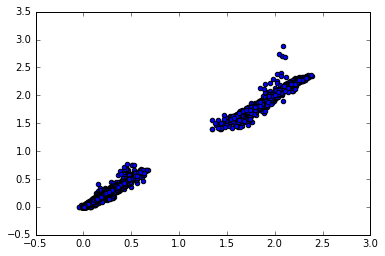

In [11]:
y_predictions = net.predict(x)
# y_predictions.shape
plt.scatter(y_predictions[:1000,:].flatten(), y[:1000,:].flatten())